In [1]:
import os
import numpy as np
import pandas as pd
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.models import Sequential

In [2]:
from tensorflow.python.client import device_lib
print("num GPU ",len(tf.config.experimental.list_physical_devices('GPU')))
print(device_lib.list_local_devices())

num GPU  1
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4035655431290294566
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1401752372
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4286626533522879279
physical_device_desc: "device: 0, name: GeForce MX330, pci bus id: 0000:2b:00.0, compute capability: 6.1"
]


In [3]:
base_dir = "..\mini project"
img_folder = os.path.join(base_dir, 'imgs/')
train_imgs = os.path.join(img_folder, 'train/')
test_imgs = os.path.join(base_dir, 'test_set/')

print('Number of images in training set = ',str(len(glob(train_imgs+'*/*'))))
print('Number of images in testing set = ',str(len(glob(test_imgs+'*'))))

Number of images in training set =  21464
Number of images in testing set =  10


In [4]:
classes = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']

class_def = {'c0': 'safe driving',
'c1': 'texting - right',
'c2': 'talking on the phone - right',
'c3': 'texting - left',
'c4': 'talking on the phone - left',
'c5': 'operating the radio',
'c6': 'drinking',
'c7': 'reaching behind',
'c8': 'hair and makeup',
'c9': 'talking to passenger'}

In [5]:
train_datagen = ImageDataGenerator(rescale=1./255,validation_split=.12)
test_datagen = ImageDataGenerator(rescale=1./255)

In [6]:
image_size = (220, 220)
batch_size = 16
train_dir = "../mini project/imgs/train/"

print("Training images")
train_generator = train_datagen.flow_from_directory(train_dir,
                                                  #class = 'inferred',
                                                  class_mode='categorical',
                                                  target_size=image_size,
                                                  batch_size=batch_size,
                                                  seed=1,
                                                  shuffle=True,
                                                  subset='training')
print("Validation images")
val_generator = train_datagen.flow_from_directory(train_dir,
                                                  #class = 'inferred',
                                                  class_mode='categorical',
                                                  target_size=image_size,
                                                  batch_size=batch_size,
                                                  seed=1,
                                                  shuffle=True,
                                                  subset='validation')
print("Test images")
test_generator=test_datagen.flow_from_directory(directory=test_imgs,
                                                class_mode="categorical",
                                                target_size=image_size,
                                                shuffle=False,
                                                batch_size=batch_size)

Training images
Found 18894 images belonging to 10 classes.
Validation images
Found 2570 images belonging to 10 classes.
Test images
Found 960 images belonging to 10 classes.


In [7]:
IMAGE_SIZE = [220, 220]
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
vgg.input

<KerasTensor: shape=(None, 220, 220, 3) dtype=float32 (created by layer 'input_1')>

In [8]:
for layer in vgg.layers:
  layer.trainable = False

In [9]:
x = Flatten()(vgg.output)
prediction = Dense(10, activation='softmax')(x)
model = Model(inputs=vgg.input, outputs=prediction)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 220, 220, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 220, 220, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 220, 220, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 110, 110, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 110, 110, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 110, 110, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 55, 55, 128)       0     

In [10]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [11]:
model.fit(train_generator,
          steps_per_epoch=50,
          epochs=10,
          validation_data=val_generator,
          validation_steps=50)

Epoch 1/10
50/50 [==============================] - 278s 4s/step - loss: 3.1202 - accuracy: 0.2800 - val_loss: 2.5129 - val_accuracy: 0.3400
Epoch 2/10
50/50 [==============================] - 206s 4s/step - loss: 1.2528 - accuracy: 0.6000 - val_loss: 1.9027 - val_accuracy: 0.4387
Epoch 3/10
50/50 [==============================] - 206s 4s/step - loss: 0.7740 - accuracy: 0.7462 - val_loss: 0.6939 - val_accuracy: 0.7713
Epoch 4/10
50/50 [==============================] - 206s 4s/step - loss: 0.4773 - accuracy: 0.8350 - val_loss: 0.6317 - val_accuracy: 0.8050
Epoch 5/10
50/50 [==============================] - 206s 4s/step - loss: 0.4766 - accuracy: 0.8537 - val_loss: 0.2300 - val_accuracy: 0.9325
Epoch 6/10
50/50 [==============================] - 206s 4s/step - loss: 0.2801 - accuracy: 0.9062 - val_loss: 0.3921 - val_accuracy: 0.8712
Epoch 7/10
50/50 [==============================] - 206s 4s/step - loss: 0.2563 - accuracy: 0.9187 - val_loss: 0.1441 - val_accuracy: 0.9538
Epoch 8/10
50

In [12]:
model.save('vgg_model2.h5')

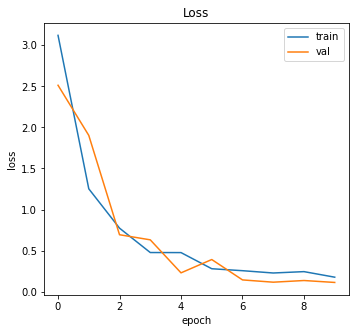

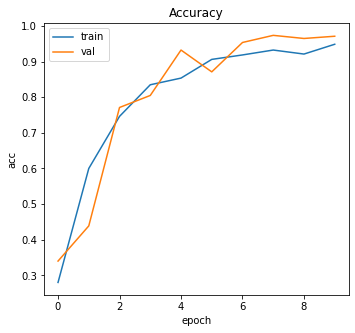

In [13]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

plt.figure(figsize=(12,5))
plt.subplot(1,2,2)
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('Accuracy')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.legend(['train', 'val'])

plt.show()